## Imports

In [1]:
# File
import pathlib

In [2]:
# Data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
# Charting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Deep Learning
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, MaxPool1D, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


## Preprocessing functions

In [5]:
def walk_forward(df, x_labels, y_labels, n, n_input_labels, 
                 split_per=None, split_data=False, y_offset=0):
    
    td_shape = df.shape
    td_l = td_shape[0]
    
    x_indices = [range(i, i+n) for i in range(td_l-n)]
    y_indices = [range(i+y_offset, i+n) for i in range(td_l-n)]
    
    x = df.loc[:, x_labels].values[x_indices]
    y = df.loc[:, y_labels].values[y_indices]
    
    if split_data:
        split_index = int(len(x)*split_per)
        x = x.reshape(-1, n, n_input_labels, 1)
        y = y.reshape(-1, n-y_offset)
        X_train, X_test, y_train, y_test = (x[:split_index], x[split_index:], y[:split_index], y[split_index:])
        return X_train, X_test, y_train, y_test
    
    return x, y

In [6]:
def batch_sequence_split(df, x_labels, y_labels, n, n_input_labels, split_index):
    
    X_train = df[x_labels].iloc[:split_index].values.reshape(-1, n, n_input_labels, 1)
    X_test = df[x_labels].iloc[split_index:].values.reshape(-1, n, n_input_labels, 1)
    y_train = df[y_labels].iloc[:split_index].values.reshape(-1, n)
    y_test = df[y_labels].iloc[split_index:].values.reshape(-1, n)
    
    return X_train, X_test, y_train, y_test

## Get Data

In [23]:
train_df = pd.read_pickle('./data/train_df.pkl')

In [8]:
train_10noise_df = (pd.read_pickle('./data/10per_noise_train_df.pkl'))

In [25]:
train_df = train_10noise_df.iloc[:100000, :].join(train_df['disp'])

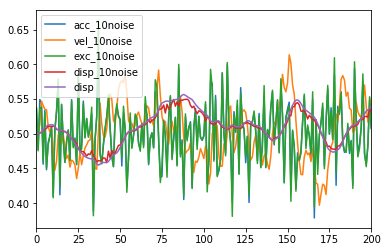

In [26]:
train_df.loc[:200, :].plot()

In [27]:
train_df.head()

,acc_10noise,vel_10noise,exc_10noise,disp_10noise,disp
0,0.535463,0.500001,0.537666,0.500069,0.500082
1,0.477690,0.504961,0.475392,0.500196,0.500266
2,0.549265,0.512874,0.536868,0.500836,0.500894
3,0.544417,0.546960,0.538491,0.502288,0.502817
4,0.456147,0.541011,0.461039,0.504688,0.505744


## Preprocessing

### Some config params

In [28]:
td_shape = train_df.shape
td_l = td_shape[0]

In [29]:
x_labels = ['exc_10noise', 'acc_10noise', 'vel_10noise']
y_labels = ['disp']

In [80]:
n = 500
n_input_labels = len(x_labels)
y_offset = 250

In [81]:
train_percentage = 0.7
length_train_data = len(train_df)
split_index = int(length_train_data*train_percentage)

In [82]:
split_index

70000

## Get train and test data

### Walk forward

In [83]:
X_train, X_test, y_train, y_test = walk_forward(train_df, 
                                                x_labels, y_labels, 
                                                n, n_input_labels, y_offset=y_offset,
                                                split_per=0.7, split_data=True)

# X_train = X_train.reshape(-1, n, n_input_labels, 1)
# y_train = y_train.reshape(-1, n-y_offset)

# X_test = train_df[x_labels].iloc[split_index:, :].values.reshape(-1, n, n_input_labels, 1)
# y_test = train_df[y_labels].iloc[split_index:, :].values

# y_test_indices = [range(i+y_offset, i+n) for i in range(0, len(train_df.iloc[split_index:, :])-n+1, n)]
# y_test = y_test[y_test_indices].reshape(-1, n-y_offset)

### Batched sequences

In [84]:
# X_train, X_test, y_train, y_test = batch_sequence_split(train_df, 
#                                                         x_labels, 
#                                                         y_labels, 
#                                                         n, 
#                                                         n_input_labels,
#                                                         split_index)

## Model

In [129]:
class Model():
    
    def __init__(self):
        self.mdl = None
        self.hist = None

    def create_model(self, input_shape, n_outputs):

        # Optimiser
        opt = Adam(lr=0.01)

        # define model
        self.mdl = Sequential()
        
        self.mdl.add(Conv2D(9, (2,3), input_shape=input_shape))
        self.mdl.add(MaxPooling2D(pool_size=(2,1)))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())

        self.mdl.add(Conv2D(9, (2,1)))
        self.mdl.add(MaxPooling2D(pool_size=(2,1)))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())

        self.mdl.add(Conv2D(9, (2,1)))
        self.mdl.add(Dropout(0.2))
        self.mdl.add(BatchNormalization())
        
        self.mdl.add(Flatten())
        self.mdl.add(Dense(300, activation='sigmoid'))

        self.mdl.add(Dense(n_outputs))

        # Prepare model for training
        self.mdl.compile(loss='mae',
                      optimizer=opt,
                      metrics=['mse'])

    
    def run_model(self, X_train, X_test, y_train, y_test):
    
        # Fit model
        self.hist = self.mdl.fit(X_train, y_train,
                            batch_size=2000,
                            epochs=20,
                            verbose=True,
                            validation_data=(X_test, y_test))

In [130]:
# Create Model
model = Model()
model.create_model(X_train[0].shape, n-y_offset)

In [131]:
model.mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 499, 1, 9)         63        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 249, 1, 9)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 249, 1, 9)         0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 249, 1, 9)         36        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 248, 1, 9)         171       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 124, 1, 9)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 124, 1, 9)         0         
__________

In [132]:
model.run_model(X_train, X_test, y_train, y_test)

Train on 69650 samples, validate on 29850 samples
Epoch 1/20
69650/69650 [==============================] - 3s 40us/step - loss: 0.2244 - mean_squared_error: 0.1265 - val_loss: 0.0822 - val_mean_squared_error: 0.0107
Epoch 2/20
69650/69650 [==============================] - 1s 18us/step - loss: 0.0404 - mean_squared_error: 0.0026 - val_loss: 0.0843 - val_mean_squared_error: 0.0091
Epoch 3/20
69650/69650 [==============================] - 1s 19us/step - loss: 0.0301 - mean_squared_error: 0.0015 - val_loss: 0.1909 - val_mean_squared_error: 0.0430
Epoch 4/20
69650/69650 [==============================] - 1s 18us/step - loss: 0.0260 - mean_squared_error: 0.0011 - val_loss: 0.0349 - val_mean_squared_error: 0.0018
Epoch 5/20
69650/69650 [==============================] - 1s 18us/step - loss: 0.0244 - mean_squared_error: 9.4636e-04 - val_loss: 0.0187 - val_mean_squared_error: 5.5385e-04
Epoch 6/20
69650/69650 [==============================] - 1s 17us/step - loss: 0.0229 - mean_squared_error:

## Evaluation

In [133]:
# Scores
print(model.mdl.evaluate(X_test, y_test, verbose=0))

[0.018807771081725756, 0.000566071600610721]


                  0
count  7.462500e+06
mean  -7.739783e-03
std    2.249816e-02
min   -1.254034e-01
25%   -2.240106e-02
50%   -7.217586e-03
75%    7.506508e-03
max    1.046892e-01


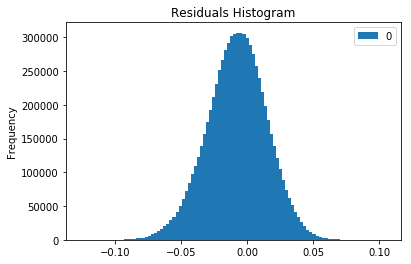

In [134]:
# Error plot (%)
preds = model.mdl.predict(X_test)
resids_all = preds-y_test
resids = pd.DataFrame((preds - y_test).reshape(-1))
resids.plot(kind='hist', bins=100, title='Residuals Histogram')
print(resids.describe())

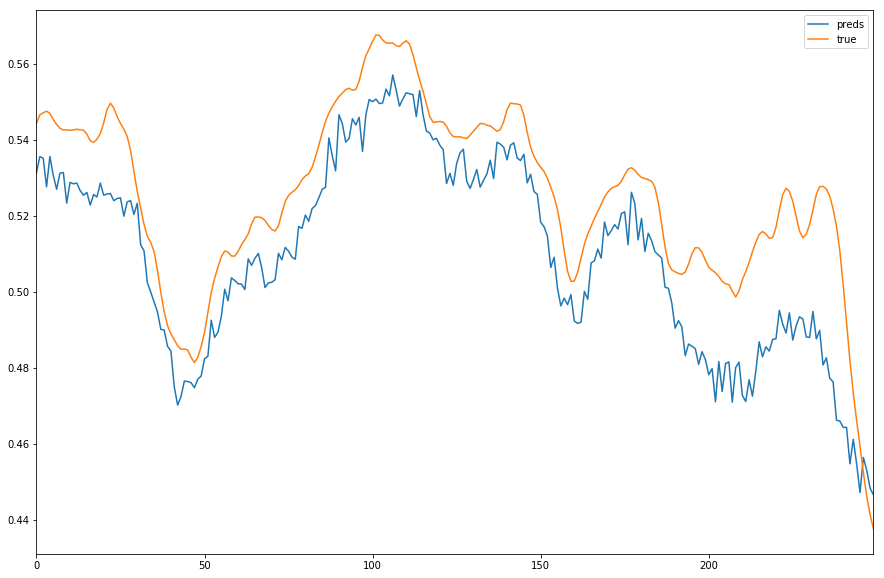

In [135]:
comp_ind = 1000
comparison = pd.concat([pd.DataFrame(preds[comp_ind].reshape(-1), columns=['preds']), 
                        pd.DataFrame(y_test[comp_ind].reshape(-1), columns=['true'])], axis=1)
comparison.plot(figsize=(15,10))

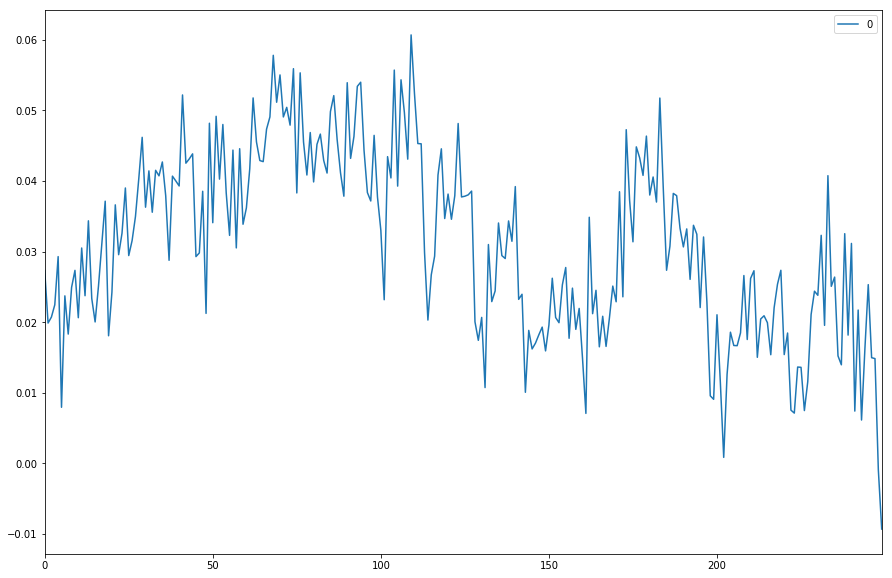

In [136]:
pd.DataFrame((resids_all[0])).plot(figsize=(15,10))

In [137]:
comparison.std()

preds    0.025501
true     0.023691
dtype: float64

In [138]:
comparison.mean()

preds    0.509616
true     0.525207
dtype: float64

In [139]:
r2_score(y_test, preds)

0.7497480593657774

## Scaled

In [ ]:
disp_raw = np.genfromtxt('./data/disp.csv', delimiter=',')

In [ ]:
disp_df = pd.DataFrame(disp_raw.T, columns=['disp', 'disp_10noise'])['disp_10noise']

In [ ]:
mean = disp_df.mean()
minimum = disp_df.min()
maximum = disp_df.max()

In [ ]:
scaled_resids = pd.DataFrame(((((resids_all -0.5) * 2.0) * (maximum - minimum)) + mean).reshape(-1))

In [ ]:
scaled_resids.mean()

In [ ]:
scaled_resids.plot(kind='hist', bins=100, figsize=(15,10), title='Errors Histogram for SDOF Problem with 10% Noise')
print('Error Standard Deviation: %E' % scaled_resids.std())
print('Error Mean: %E' % scaled_resids.mean())